# Práctica MLP con Detección de Fraude en Tarjetas de Crédito

Importamos las librerías de numpy, pandas y matplotlib y cargamos los datos de la base de datos que se nos ha proporcionado. 

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
dataset = pd.read_csv("../../creditcard.csv")
print(dataset)

            Time         V1         V2        V3        V4        V5  \
0            0.0  -1.359807  -0.072781  2.536347  1.378155 -0.338321   
1            0.0   1.191857   0.266151  0.166480  0.448154  0.060018   
2            1.0  -1.358354  -1.340163  1.773209  0.379780 -0.503198   
3            1.0  -0.966272  -0.185226  1.792993 -0.863291 -0.010309   
4            2.0  -1.158233   0.877737  1.548718  0.403034 -0.407193   
...          ...        ...        ...       ...       ...       ...   
284802  172786.0 -11.881118  10.071785 -9.834783 -2.066656 -5.364473   
284803  172787.0  -0.732789  -0.055080  2.035030 -0.738589  0.868229   
284804  172788.0   1.919565  -0.301254 -3.249640 -0.557828  2.630515   
284805  172788.0  -0.240440   0.530483  0.702510  0.689799 -0.377961   
284806  172792.0  -0.533413  -0.189733  0.703337 -0.506271 -0.012546   

              V6        V7        V8        V9  ...       V21       V22  \
0       0.462388  0.239599  0.098698  0.363787  ... -0.01830

## Carga de librerías para el MLP

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss, accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from datetime import datetime

## Visualización de datos


Una vez cargados en memoria los datos (en este caso, con información sobre transacciones bancarias fraudulentas), visualizamos cuántas entradas de la base de datos que corresponden a fraudes (Class 1) y cuantas no (Class 0).

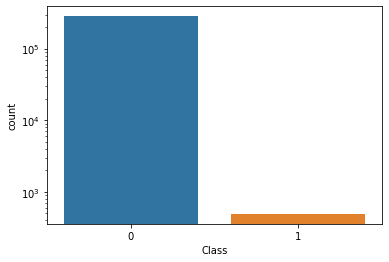

In [8]:
import seaborn as sn
ax=sn.countplot(x='Class',data=dataset);
ax.set_yscale('log')

## Undersampling
Dado que la base de datos está enormemente desbalanceada, para que el aprendizaje sea efectivo debemos equilibrar el número de fraudes y no fraudes. Para ello, usamos la técnica de <i>undersampling</i>. También existe el <i>upsampling</i> pero en este caso hemos probado con <i>undersampling</i> ya que, cuando analizamos resultados con ambas técnicas en fase de preprocesamiento, arrojó mejores resultados el <i>undersampling</i>.

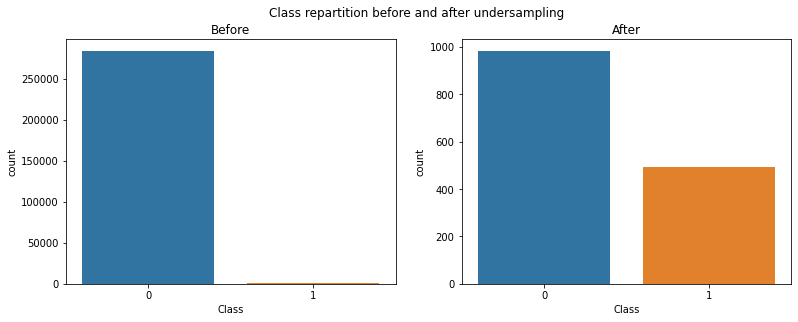

In [9]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler 

undersample = RandomUnderSampler(sampling_strategy=0.5, random_state=2)

cols = dataset.columns.tolist()
cols = [c for c in cols if c not in ["Class"]]
target = "Class"

#define X and Y
X = dataset[cols]
Y = dataset[target]

#undersample
X_under, Y_under = undersample.fit_resample(X, Y)
test = pd.DataFrame(Y_under, columns = ['Class'])

fig, axs = plt.subplots(ncols=2, figsize=(13,4.5))
sn.countplot(x="Class", data=dataset, ax=axs[0])
sn.countplot(x="Class", data=test, ax=axs[1])

fig.suptitle("Class repartition before and after undersampling")
a1=fig.axes[0]
a1.set_title("Before")
a2=fig.axes[1]
a2.set_title("After")

dataset = pd.concat([X_under, Y_under], axis=1)

## Creación de sets(train, valid y test)
Dividiremos la base de datos, en tres grupos principales:
* Train: lo usaremos para entrenar la red.
* Valid: lo usaremos para mejorar la arquitectura de la red
* Test: es el conjunto final de datos para comprobar el rendimiento real de nuestra red. 

In [10]:
from pandas import DataFrame

# Data preprocessing
train_size = 0.75
test_size = 1 - train_size
train, test = train_test_split(dataset, test_size = test_size)
patterns_input = train.iloc[:,1:30].values[:]
input_test = test.iloc[:,1:30].values[:]

patterns_target = train.iloc[:,-1].values[:]
target_test = test['Class'].values[:]

input_train, input_valid, target_train, target_valid = train_test_split(
    patterns_input, patterns_target, train_size=train_size, test_size=test_size,
    random_state=0, shuffle=True)

print(input_train.shape, target_train.shape)
print(input_valid.shape, target_valid.shape)

(830, 29) (830,)
(277, 29) (277,)


## Perceptrón Simple

Entrenamos el modelo Perceptrón Simple con 30 iteraciones, que nos informará del punto hasta el cual el problema es separable linealmente.

In [11]:
max_iter = 30
per = Perceptron(max_iter=max_iter, shuffle=False, random_state=0, verbose=True)
per.fit(input_train, target_train)
predict_train = per.predict(input_train)
predict_valid = per.predict(input_valid)
print("Train accuracy: %.3f%%" % (accuracy_score(target_train, predict_train) * 100))
print("Valid accuracy: %.3f%%" % (accuracy_score(target_valid, predict_valid) * 100))

-- Epoch 1
Norm: 828.44, NNZs: 29, Bias: -171.000000, T: 830, Avg. loss: 13014.308867
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 936.66, NNZs: 29, Bias: -363.000000, T: 1660, Avg. loss: 12519.997741
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 1124.40, NNZs: 29, Bias: -544.000000, T: 2490, Avg. loss: 12719.239323
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 1400.67, NNZs: 29, Bias: -709.000000, T: 3320, Avg. loss: 12435.672505
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 1599.07, NNZs: 29, Bias: -868.000000, T: 4150, Avg. loss: 12749.434635
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 1702.58, NNZs: 29, Bias: -1019.000000, T: 4980, Avg. loss: 9056.025203
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 1979.11, NNZs: 29, Bias: -1150.000000, T: 5810, Avg. loss: 12009.792451
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 2215.77, NNZs: 29, Bias: -1303.000000, T: 6640, Avg. loss: 12112.782192
Total training time: 0.00 seconds.
-- Epoch 9
Norm: 

# Resultados iniciales Perceptrón Multicapa

Implementamos la función **MLP_train_valid()** para posibilitar la realización de entrenamientos del MLP (Perceptrón Multicapa), incluyendo validaciones con el conjunto de validación e imprimiendo información de cada iteración.

Learning a MLP with 60 hidden neurons, 300 maximum number of iterations and 0.00100000 learning rate ...
Iteration 5, train loss = 4.92802878, valid loss = 3.72973795
Iteration 10, train loss = 0.98491570, valid loss = 1.04649185
Iteration 15, train loss = 0.46025269, valid loss = 0.46164071
Iteration 20, train loss = 0.35959411, valid loss = 0.34270021
Iteration 25, train loss = 0.28488318, valid loss = 0.26937926
Iteration 30, train loss = 0.22871105, valid loss = 0.21782078
MLPClassifier(hidden_layer_sizes=(60,), random_state=0, shuffle=False)
Visualizing the Cost Function Trajectory


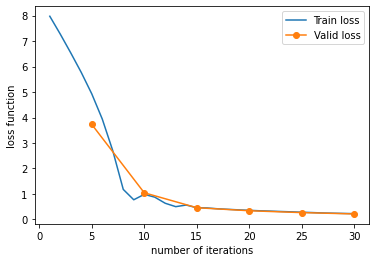

In [12]:
max_iter = 30

def MLP_train_valid(mlp, input_train, target_train, input_valid, target_valid, max_iter, valid_cycles, verbose):
    """
    Train and valid MLP every valid_cycles iterations
    """
    classes = np.unique(target_train)
    loss_valid = []
    for i in range(6):
        for j in range(valid_cycles):
            out = mlp.partial_fit(input_train, target_train, classes)
            # Calculate loss function of valid set
        last_lost_valid = log_loss(target_valid, mlp.predict_proba(input_valid))
        loss_valid.append(last_lost_valid)
        if verbose:
            print("Iteration %d, train loss = %.8f, valid loss = %.8f" %
                  (mlp.n_iter_, mlp.loss_, last_lost_valid))
        if early_stopping and (i > 0) and (last_lost_valid > loss_valid[-2]): # Early stopping
            if verbose:
                print("Early stopping: Validation score did not improve")
            break
    if verbose: 
        print(out)
        print("Visualizing the Cost Function Trajectory")
        plt.plot(range(1, len(mlp.loss_curve_)+1), mlp.loss_curve_, label='Train loss')
        plt.plot(range(valid_cycles,len(loss_valid)*valid_cycles+valid_cycles,valid_cycles), loss_valid, '-o', label='Valid loss')
        plt.xlabel('number of iterations')
        plt.ylabel('loss function')
        plt.legend(loc='upper right')
        plt.show()

n_hidden = 60
max_iter = 300
learning_rate_init = 0.001
valid_cycles = 5
early_stopping = True

print("Learning a MLP with %d hidden neurons, %d maximum number of iterations and %.8f learning rate ..." % (n_hidden, max_iter, learning_rate_init))

mlp = MLPClassifier(hidden_layer_sizes=(n_hidden,), learning_rate_init=learning_rate_init, shuffle=False, random_state=0, verbose=False)

MLP_train_valid(mlp, input_train, target_train, input_valid, target_valid, max_iter, valid_cycles, True)


Podemos observar que los errores bajan más notablemente a las 15 iteraciones, deteniendo el entrenamiento a las 30 iteraciones y sin producirse sobreentrenamiento. A continuación mostramos los resultados iniciales de dicho entrenamiento:

In [13]:
predict_train = mlp.predict(input_train)
predict_valid = mlp.predict(input_valid)
print("Train accuracy: %.3f%%" % (accuracy_score(target_train, predict_train) * 100))
print("Valid accuracy: %.3f%%" % (accuracy_score(target_valid, predict_valid) * 100))
print("Train confusion matrix:")
print(confusion_matrix(target_train, predict_train))
print("Valid confusion matrix:")
print(confusion_matrix(target_valid, predict_valid))
print("Train classification report:")
print(classification_report(target_train, predict_train))
print("Valid classification report:")
print(classification_report(target_valid, predict_valid))

Train accuracy: 94.578%
Valid accuracy: 94.224%
Train confusion matrix:
[[538  12]
 [ 33 247]]
Valid confusion matrix:
[[169   9]
 [  7  92]]
Train classification report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       550
           1       0.95      0.88      0.92       280

    accuracy                           0.95       830
   macro avg       0.95      0.93      0.94       830
weighted avg       0.95      0.95      0.95       830

Valid classification report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       178
           1       0.91      0.93      0.92        99

    accuracy                           0.94       277
   macro avg       0.94      0.94      0.94       277
weighted avg       0.94      0.94      0.94       277



La diferencia de precisión entre el Perceptrón Simple y el MLP es muy notable, mejorando en un 40,602% en el conjunto de entrenamiento y un 39,35% en el conjunto de validación.

## Optimización ratio de aprendizaje

Aceleramos la convergencia de los MLP buscando un ratio de aprendizaje más adecuado, probando con diferentes valores entre 0.001 y 0.1. Visualizamos también las gráficas de la evolución del error a lo largo de los ciclos para los distintos ratios de aprendizaje estudiados.

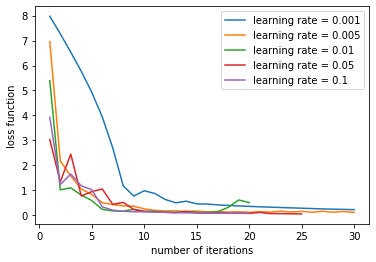

In [14]:
tests_learning_rate_init = [0.001, 0.005, 0.01, 0.05, 0.1]
activation = 'relu'
random_state = 0
now = datetime.now()
loss_curves =  []
for lr in tests_learning_rate_init:
   mlp = MLPClassifier(hidden_layer_sizes=(n_hidden,), learning_rate_init=lr, shuffle=False, random_state=random_state, verbose=False, activation=activation)
   MLP_train_valid(mlp, input_train, target_train, input_valid, target_valid, max_iter, valid_cycles, False)
   loss_curves.append(mlp.loss_curve_)
for (lr, loss_curve) in zip(tests_learning_rate_init, loss_curves):
   plt.plot(range(1, len(loss_curve)+1), loss_curve, label='learning rate = ' + str(lr))
plt.xlabel('number of iterations')
plt.ylabel('loss function')
plt.legend(loc='upper right')
plt.show()


Observando la gráfica, podemos ver que el ratio de aprendizaje 0.01 ya que a pesar de no ser el que requiere de menos iteraciones, es el que consigue estabilizarse completamente más pronto.

## Optimización arquitectura

A continuación, trataremos de mejorar los resultados de los MLP calculando el número de neuronas ocultas más adecuado, probando con valores diferentes entre 10 y 190, realizando el cálculo 10 veces con cada configuración y nos quedaremos con el valor que consiga una mayor precisión en el conjunto de validación.

In [15]:
tests_n_hidden = [10, 30, 50, 70, 90, 110, 130, 150, 170, 190]
n_reps = 10
activation = 'relu'
# activation = 'logistic'
learning_rate_init = 0.01
now = datetime.now()
best_mlp = []
best_acc = 0.0
accs_train = []
accs_valid = []
for n_hidden in tests_n_hidden:
   max_acc_train = max_acc_valid = 0.0
   for random_state in range(n_reps):
       mlp = MLPClassifier(hidden_layer_sizes=(n_hidden,), learning_rate_init=learning_rate_init, shuffle=False, random_state=random_state, verbose=False, activation=activation)
       MLP_train_valid(mlp, input_train, target_train, input_valid, target_valid, max_iter, valid_cycles, False)
       
       acc_train = accuracy_score(target_train, mlp.predict(input_train))
       acc_valid = accuracy_score(target_valid,mlp.predict(input_valid))
       print("Seed = %d, train acc = %.8f, valid acc = %.8f, iterations = %d" % (random_state, acc_train, acc_valid, len(mlp.loss_curve_)))
       if (max_acc_valid < acc_valid):
           max_acc_valid = acc_valid
           max_acc_train = acc_train
           if (acc_valid > best_acc):
               best_acc = acc_valid
               best_mlp = mlp
   accs_train.append(max_acc_train)
   accs_valid.append(max_acc_valid)
   print("Number hidden units = %i, train acc = %.8f, max valid acc = %.8f" % (n_hidden, max_acc_train, max_acc_valid))
print("Number of seconds for training: %d" % (datetime.now() - now).total_seconds())
print("Best MLP valid accuracy: %.8f%%" % (best_acc * 100))
print("Best MLP: ", best_mlp)

Seed = 0, train acc = 0.95662651, valid acc = 0.95667870, iterations = 30
Seed = 1, train acc = 0.95060241, valid acc = 0.95667870, iterations = 30
Seed = 2, train acc = 0.95421687, valid acc = 0.95667870, iterations = 30
Seed = 3, train acc = 0.93855422, valid acc = 0.94584838, iterations = 10
Seed = 4, train acc = 0.96144578, valid acc = 0.96028881, iterations = 30
Seed = 5, train acc = 0.96024096, valid acc = 0.95667870, iterations = 30
Seed = 6, train acc = 0.94939759, valid acc = 0.96028881, iterations = 30
Seed = 7, train acc = 0.95421687, valid acc = 0.96028881, iterations = 30
Seed = 8, train acc = 0.96265060, valid acc = 0.96389892, iterations = 30
Seed = 9, train acc = 0.93373494, valid acc = 0.92057762, iterations = 20
Number hidden units = 10, train acc = 0.96265060, max valid acc = 0.96389892
Seed = 0, train acc = 0.95180723, valid acc = 0.94945848, iterations = 25
Seed = 1, train acc = 0.96506024, valid acc = 0.96389892, iterations = 30
Seed = 2, train acc = 0.95421687, v

Como podemos ver, el mejor MLP encontrado tiene 30 neuronas en la capa oculta.

## Resultados de las distintas redes con número de neuronas ocultas distinto

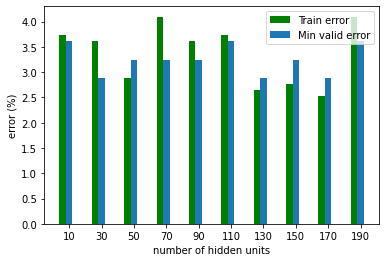

In [16]:
width = 4
plt.bar(np.array(tests_n_hidden) - width, 100 *(1- np.array(accs_train)), color='g', width=width, label='Train error')
plt.bar(np.array(tests_n_hidden), 100 *(1- np.array(accs_valid)), width=width, label='Min valid error')
plt.xlabel('number of hidden units')
plt.ylabel('error (%)')
plt.xticks(np.array(tests_n_hidden), tests_n_hidden)
plt.legend(loc='upper right')
plt.show()

En la gráfica se puede observar que para 30 y 50 neuronas ocultas los resultados son prácticamente iguales (en nuestro caso, el mejor MLP obtenido tiene 30) y a partir de las 50, los resultados suben y tienen variaciones.

A continación, se muestran los resultados finales del mejor MLP obtenido, incluido el conjunto de test:

In [17]:
print("Printing final results")

predict_train = best_mlp.predict(input_train)
predict_valid = best_mlp.predict(input_valid)
predict_test = best_mlp.predict(input_test)

print("Train accuracy: %.3f%%" % (accuracy_score(target_train, predict_train) * 100))
print("Valid accuracy: %.3f%%" % (accuracy_score(target_valid, predict_valid) * 100))
print("Test accuracy: %.3f%%" % (accuracy_score(target_test, predict_test) * 100))

print("Train confusion matrix:")
print(confusion_matrix(target_train, predict_train))
print("Valid confusion matrix:")
print(confusion_matrix(target_valid, predict_valid))
print("Test confusion matrix:")
print(confusion_matrix(target_test, predict_test))

print("Train classification report:")
print(classification_report(target_train, predict_train))
print("Valid classification report:")
print(classification_report(target_valid, predict_valid))
print("Test classification report:")
print(classification_report(target_test, predict_test))

Printing final results
Train accuracy: 96.386%
Valid accuracy: 97.112%
Test accuracy: 96.206%
Train confusion matrix:
[[550   0]
 [ 30 250]]
Valid confusion matrix:
[[178   0]
 [  8  91]]
Test confusion matrix:
[[253   3]
 [ 11 102]]
Train classification report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       550
           1       1.00      0.89      0.94       280

    accuracy                           0.96       830
   macro avg       0.97      0.95      0.96       830
weighted avg       0.97      0.96      0.96       830

Valid classification report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       178
           1       1.00      0.92      0.96        99

    accuracy                           0.97       277
   macro avg       0.98      0.96      0.97       277
weighted avg       0.97      0.97      0.97       277

Test classification report:
              precision   

Podemos observar que los resultados finaless del mejor MLP obtenido mejoran respecto al Perceptrón Simple 43,494% para el conjunto de entrenamiento y un 42,238% para el conjunto de validación, mejorando la generalización respecto al MLP inicial. El error final para el conjunto de test es 95,122%, un 0,176% mejor que el conjunto de validación. 

A continuación se muestran también las curvas ROC para el conjunto de test, en ella se puede ver que ambas clases son predichas con igual error.

[[9.79780850e-01 2.02191502e-02]
 [9.99786254e-01 2.13745959e-04]
 [9.05556374e-01 9.44436261e-02]
 [9.99990460e-01 9.53960120e-06]
 [0.00000000e+00 1.00000000e+00]
 [9.99216051e-01 7.83948980e-04]
 [9.95937167e-01 4.06283318e-03]
 [9.56018240e-01 4.39817600e-02]
 [9.98922050e-01 1.07795011e-03]
 [0.00000000e+00 1.00000000e+00]
 [9.99998180e-01 1.82010485e-06]
 [9.83773266e-01 1.62267342e-02]
 [9.98620186e-01 1.37981432e-03]
 [9.89043452e-01 1.09565484e-02]
 [8.93795358e-01 1.06204642e-01]
 [1.00000000e+00 4.88185412e-14]
 [0.00000000e+00 1.00000000e+00]
 [9.65812010e-01 3.41879898e-02]
 [0.00000000e+00 1.00000000e+00]
 [8.77763781e-01 1.22236219e-01]
 [9.99255624e-01 7.44375961e-04]
 [9.90089044e-01 9.91095589e-03]
 [0.00000000e+00 1.00000000e+00]
 [9.89742663e-01 1.02573371e-02]
 [0.00000000e+00 1.00000000e+00]
 [9.89827748e-01 1.01722521e-02]
 [9.99558297e-01 4.41703267e-04]
 [9.67836999e-01 3.21630005e-02]
 [9.99393881e-01 6.06118559e-04]
 [9.94564961e-01 5.43503893e-03]
 [9.998580

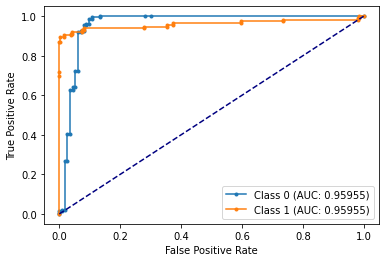

In [21]:
# TODO que se haga con 1
mlp_probs = mlp.predict_proba(input_test)
print(mlp_probs)
classes  = np.unique(target_train)
mlp_auc = []
mlp_fpr = []
mlp_tpr = []
for cla in classes:
   mlp_auc.append(roc_auc_score(target_test==cla, mlp_probs[:,cla]))
   fpr, tpr, _ = roc_curve(target_test==cla, mlp_probs[:,cla])
   mlp_fpr.append(fpr)
   mlp_tpr.append(tpr)
for cla in classes:
   # plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
   plt.plot(mlp_fpr[cla], mlp_tpr[cla], marker='.', label='Class %d (AUC: %.5f)' % (cla, mlp_auc[cla]))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [19]:
real_class = 1
indxs = np.where(test['Class'].values[:] == real_class)[0]
indxs_err = indxs[(np.where(predict_test[(indxs)] != real_class)[0])]
preds_err = predict_test[(indxs_err)]
print(indxs_err)

[ 10  29  48  55  71  85 109 215 269 270 298]


# Conclusión



Podemos ver cómo conocer el conjunto de datos con el que se está trabajando es de importancia durante la realización de análisis como el que se ha realizado en la presente práctica. En este caso, el conjunto altamente desbalanceado de transacciones fraudulentas registradas dificulta el proceso de aprendizaje; puesto que los modelos aquí estudiados tienden a clasificar todas las entradas como la variable de clase más frecuente; en este caso, clasificaría todas las transacciones como no fraudulentas. Para contrarrestar este inconveniente, se utilizan frecuentemente técnicas como el oversampling o el downsampling (como se ha realizado en esta práctica), permitiendo manejar un conjunto de datos más representativo de los distintos escenarios en los que una transacción podría ser de interés; bajo el inconveniente de perder detalle y precisión en datos que no se encuentran incluidos dentro del conjunto seleccionado para el entrenamiento del modelo.